In [173]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ELU
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Create results csv with SQL Query if needed
data = pd.read_csv('results.csv')


1. Data Understanding

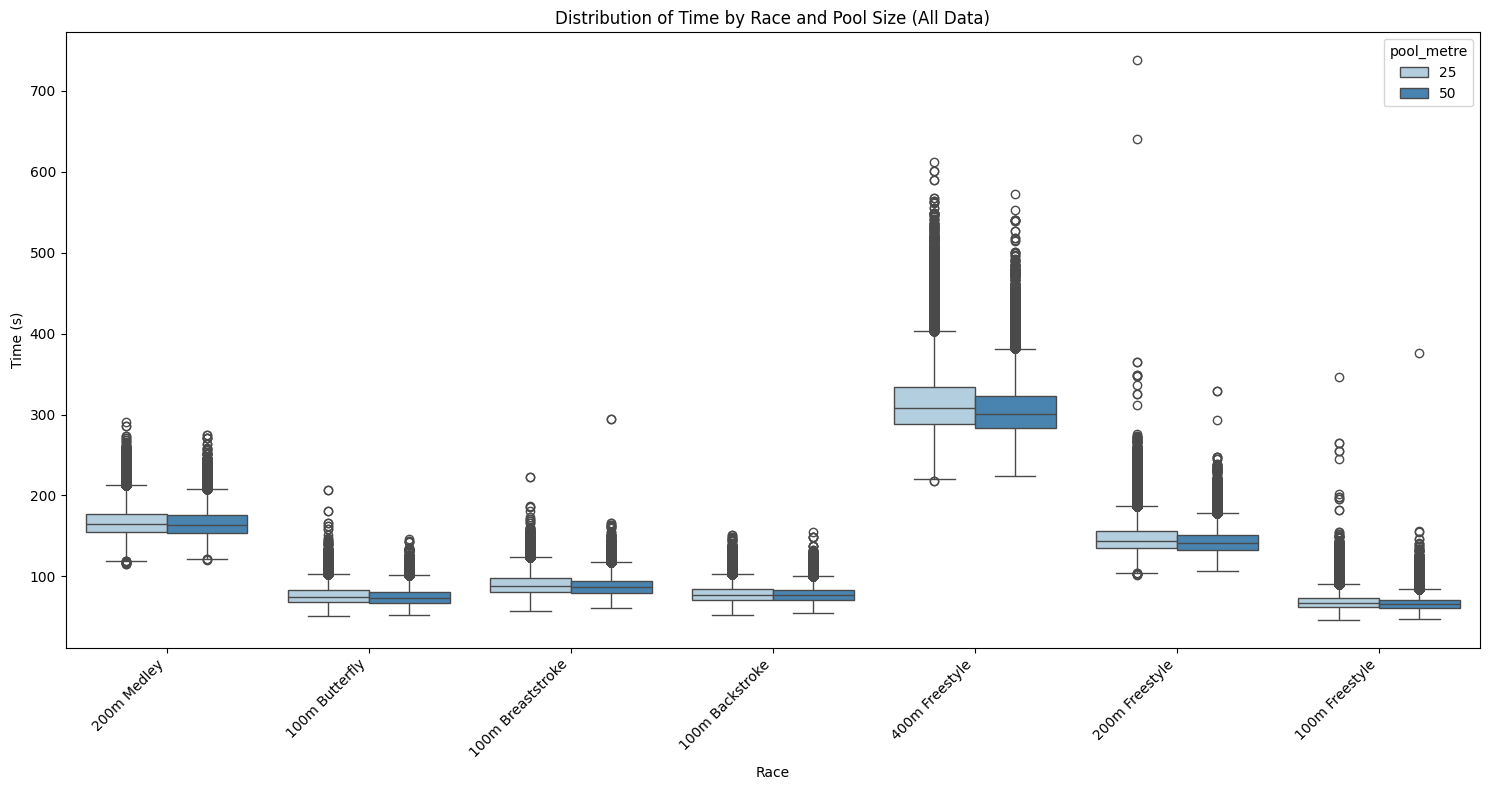

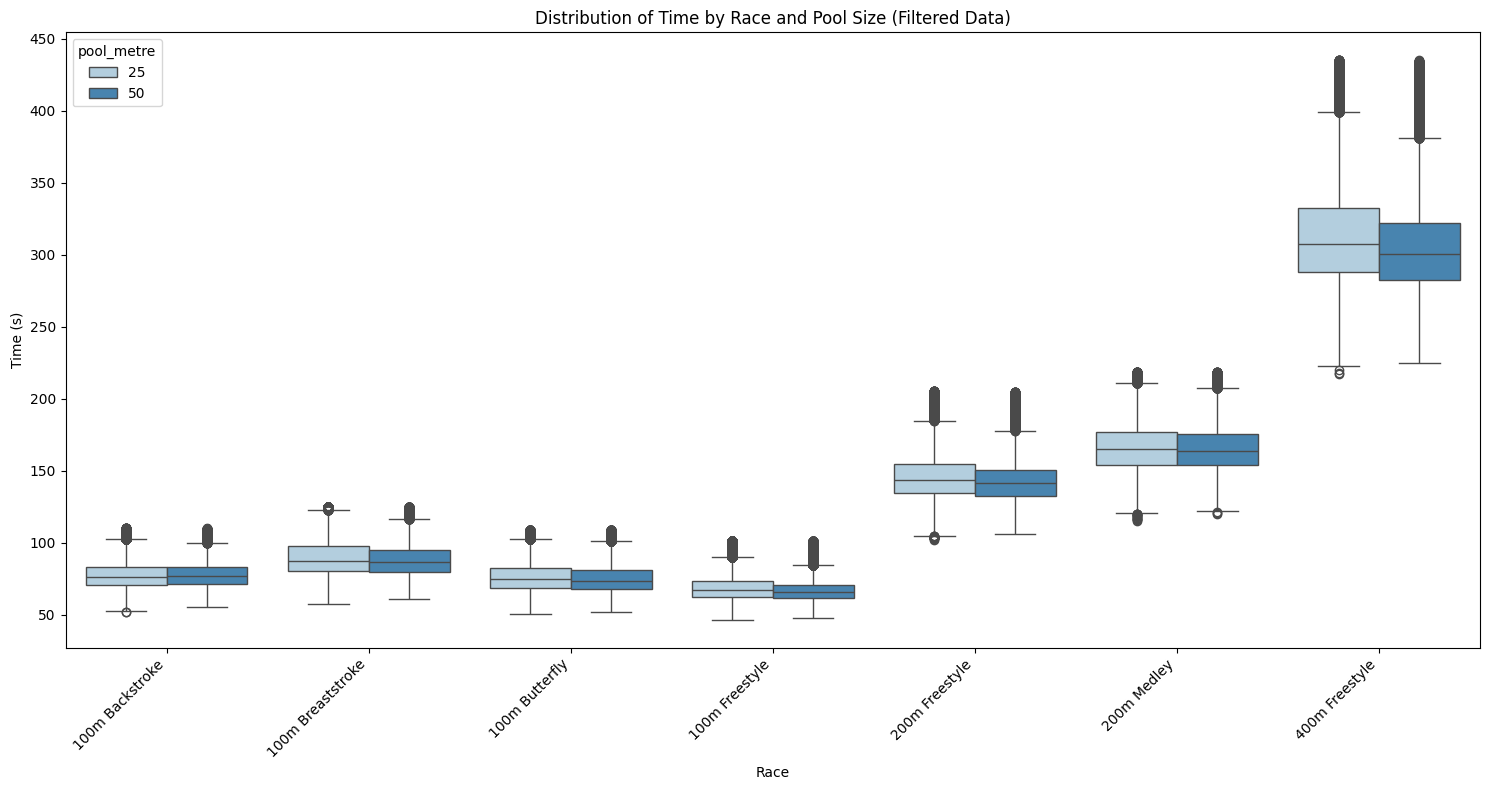

In [174]:
# Combine distance_metre and style_name to create a unique race identifier
data['race'] = data['distance_metre'].astype(str) + 'm ' + data['style_name']

# Define the order for pool_metre for consistent coloring
pool_order = ['25m', '50m']

# Set a blueish color palette
blue_palette = sns.color_palette("Blues", n_colors=len(pool_order))

# Chart 1: Distribution of data by race and pool size
plt.figure(figsize=(15, 8))
sns.boxplot(x='race', y='time_millisecond', hue='pool_metre', data=data, palette=blue_palette, order=data['race'].unique())
plt.title('Distribution of Time by Race and Pool Size (All Data)')
plt.xlabel('Race')
plt.ylabel('Time (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Chart 2: Distribution of data by race and pool size, removing extreme values
data_filtered = pd.DataFrame()

# Group by race and filter outliers within each group
for race_name, race_group in data.groupby('race'):
    # Calculate threshold for this specific race (99th percentile)
    time_threshold = race_group['time_millisecond'].quantile(0.99)
    
    # Filter out extreme values for this race
    filtered_group = race_group[race_group['time_millisecond'] < time_threshold]
    
    # Add to the filtered dataframe
    data_filtered = pd.concat([data_filtered, filtered_group])

plt.figure(figsize=(15, 8))
sns.boxplot(x='race', y='time_millisecond', hue='pool_metre', data=data_filtered, palette=blue_palette, order=data_filtered['race'].unique())
plt.title('Distribution of Time by Race and Pool Size (Filtered Data)')
plt.xlabel('Race')
plt.ylabel('Time (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

o_data = data
data = data_filtered



2. Data Preparation

In [175]:
# Convert race_date to datetime
data['race_date'] = pd.to_datetime(data['race_date'])

# Compute season year (swimming convention)
data['month'] = data['race_date'].dt.month
data['year'] = data['race_date'].dt.year
data['season_year'] = data['year']
data.loc[data['month'] <= 8, 'season_year'] -= 1

# Compute age (season_year - birth_year)
data['birth_year'] = pd.to_datetime(data['birth_year'], errors='coerce')
data['age'] = data['season_year'] - data['birth_year'].dt.year

# Normalize column names
data['time'] = data['time_millisecond']
data['distance'] = data['distance_metre']
data['stroke'] = data['style_name']
data['pool'] = data['pool_metre'].apply(lambda x: '50m' if x == 50 else '25m')

# Drop rows with missing critical values
data = data.dropna(subset=['swimmer_name', 'race_date', 'time', 'age'])

# Define the function to compute a trend score
def compute_trend(group, window=3):
    trends = []
    for i in range(len(group)):
        if i < window - 1:
            trends.append(np.nan)
        else:
            y = group['time'].iloc[i - window + 1:i + 1].values.reshape(-1, 1)
            x = np.arange(window).reshape(-1, 1)
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0][0]
            trends.append(slope)
    return pd.Series(trends, index=group.index)

# Feature Engineering
data = pd.get_dummies(data, columns=['sex', 'pool'], dtype='int')


# Process each unique race event
group_cols = ['distance', 'stroke']
event_dfs = {}

for group_key, group_df in data.groupby(group_cols):
    print(f"Processing event: {group_key}")
    group_df = group_df.sort_values(by=['swimmer_name', 'race_date']).copy()

    # Previous race time per swimmer
    group_df['previous_time'] = group_df.groupby('swimmer_name')['time'].shift(1)
    group_df.dropna(subset=['previous_time'], inplace=True)

    # Previous race date per swimmer
    group_df['previous_race'] = group_df.groupby('swimmer_name')['race_date'].shift(1)
    group_df['days_since_last_race'] = (group_df['race_date'] - group_df['previous_race']).dt.days

    # Trend score
    group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))

    # Age at first race per swimmer
    group_df['first_race_age'] = group_df.groupby('swimmer_name')['age'].transform('first')

    group_df = group_df.dropna()

    # Filter swimmers with > 5 races and presence at age 16
    group_df = group_df.groupby('swimmer_name').filter(
        lambda x: len(x) > 5 and 16 in x['age'].values # Anciennes valeurs : min 10 courses et au moins une course a 14 et 18 ans
    )

    if not group_df.empty:
        event_dfs[group_key] = group_df

print(f"Processed {len(event_dfs)} events.")

Processing event: (np.int64(100), 'Backstroke')


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\2990432312.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))


Processing event: (np.int64(100), 'Breaststroke')


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\2990432312.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))


Processing event: (np.int64(100), 'Butterfly')


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\2990432312.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))


Processing event: (np.int64(100), 'Freestyle')


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\2990432312.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))


Processing event: (np.int64(200), 'Freestyle')


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\2990432312.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))


Processing event: (np.int64(200), 'Medley')


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\2990432312.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))


Processing event: (np.int64(400), 'Freestyle')


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\2990432312.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_df['trend_score'] = group_df.groupby('swimmer_name', group_keys=False).apply(lambda g: compute_trend(g, window=3))


Processed 7 events.


2.1. Visualise Changes

Event: 100m Backstroke - Number of swimmers: 3044
Event: 100m Breaststroke - Number of swimmers: 2471
Event: 100m Butterfly - Number of swimmers: 2649
Event: 100m Freestyle - Number of swimmers: 4193


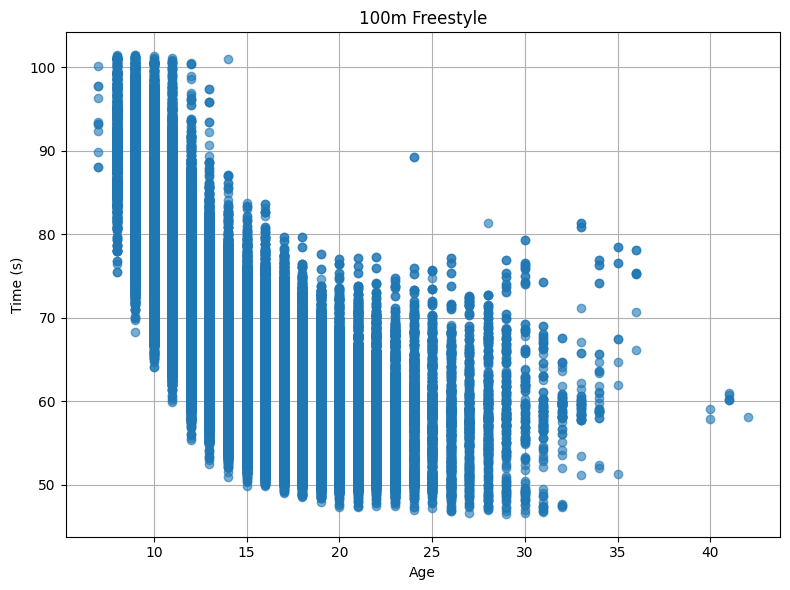

Event: 200m Freestyle - Number of swimmers: 3311
Event: 200m Medley - Number of swimmers: 2762
Event: 400m Freestyle - Number of swimmers: 2654


In [176]:
# Convert to list of (key, df) items
for (distance, stroke), df in event_dfs.items():
    # print(f"Event: {distance}m {stroke} - Number of swimmers: {df['swimmer_name'].nunique()}")
    if (stroke == 'Freestyle') & (distance == 100):
        # Compute y-axis limits with 5% padding
        times = df['time'].tolist()
        y_min = min(times)
        y_max = max(times)
        y_pad = (y_max - y_min) * 0.05
        y_min -= y_pad
        y_max += y_pad

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(df['age'], df['time'], 'o', alpha=0.6)
        plt.xlabel("Age")
        plt.ylabel("Time (s)")
        plt.title(f"{distance}m {stroke}")
        plt.ylim(y_min, y_max)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

3. Data Modeling

        a) Logistic Regression

In [177]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math, copy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

data_pr = event_dfs[(np.int64(100), 'Freestyle')].copy()

x = data_pr[['age', 'sex_M', 'pool_50m', 'previous_time', 'days_since_last_race', 'trend_score', 'first_race_age']].values  
y = data_pr['time'].values  

poly = PolynomialFeatures(degree=2)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_poly = poly.fit_transform(x)

y = scaler_y.fit_transform(y.reshape(-1, 1))
x_poly = scaler_x.fit_transform(x_poly)

x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.4, random_state=42)

def predict(x, w, b):
    p = np.dot(x, w) + b
    return p

def compute_cost(X, y, w, b, lambda_):
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b           
        cost = cost + (f_wb_i - y[i])**2       
    cost = cost / (2 * m)

    # regularisation L2 (ridge)
    regularization_cost = (lambda_ / (2 * m)) * np.sum(w**2)
    cost += regularization_cost                    
    return cost

def compute_gradient(X, y, w, b,lambda_):
    m,n = X.shape           
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    dj_dw += (lambda_ / m) * w

    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    J_history = []
    w = copy.deepcopy(w_in)  
    b = b_in

    for i in range(num_iters):
        dj_db,dj_dw = gradient_function(X, y, w, b, lambda_)  
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        if i<100000:      
            J_history.append( cost_function(X, y, w, b, lambda_))
        
        if i > 1 and abs(J_history[-1] - J_history[-2]) < 0.0001:
            print(f"Early stopping at iteration {i} as cost change is less than 0.0001")
            break 
            
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]} ",
                  f"dj_dw: {dj_dw}, dj_db: {dj_db}  ",
                  f"w: {w}, b:{b}")

    return w, b, J_history 

initial_w = np.random.randn(x_train.shape[1]) 
initial_b =  0    

lambda_ = 0.1
iterations = 1000
alpha = 0.05 
w_final, b_final, J_hist = gradient_descent(x_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient,
                                                    alpha, iterations, lambda_)

print(f"(w,b) found by gradient descent: ({w_final},{b_final})")


C:\Users\natha\AppData\Local\Temp\ipykernel_50708\3494664980.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dj_dw[j] = dj_dw[j] + err * X[i, j]


Iteration    0: Cost [7.3235624]  dj_dw: [ 9.58161957e-07  7.17973479e-01  6.48080925e-01  8.37764425e-01
 -1.61789043e+00  1.51742639e+00  1.78521298e+00 -8.51947100e-01
  6.29841846e-01  8.32190157e-01  9.07765479e-01 -2.49045179e-01
  1.32211199e+00  1.62816310e+00 -6.53462045e-02  6.48080580e-01
  1.38577787e+00  4.21660770e-01  5.37605865e-01  1.36981218e+00
  5.28676007e-01  8.37762771e-01  6.77395228e-01  1.71429981e+00
 -6.32569329e-01  6.66085327e-01 -1.59218415e+00  1.49084315e+00
  1.84949493e+00 -1.81089104e+00  7.54668565e-01 -1.16141213e-01
  1.39513787e+00 -2.04297912e+00  1.76729342e+00 -8.21707172e-01], dj_db: [0.00961003]   w: [ 1.44287688 -0.57558024  0.09597294  1.71852696  1.04743377  0.63717773
  1.21694542 -0.56200561  0.60509132  1.36764388  1.57552401 -0.79373256
 -0.31777981  0.30130702 -0.28573003 -0.42422027  0.61471243 -0.37449302
 -1.81479318  0.29335671 -0.45092659 -0.77341912 -1.59960791  0.92810748
 -2.19548417 -1.73263787 -0.19623686  1.15441343  1.217

RMSE on the test set (original scale): 2.7763087507251027
RMSE en pourcentage sur l'ensemble de test: 4.18%


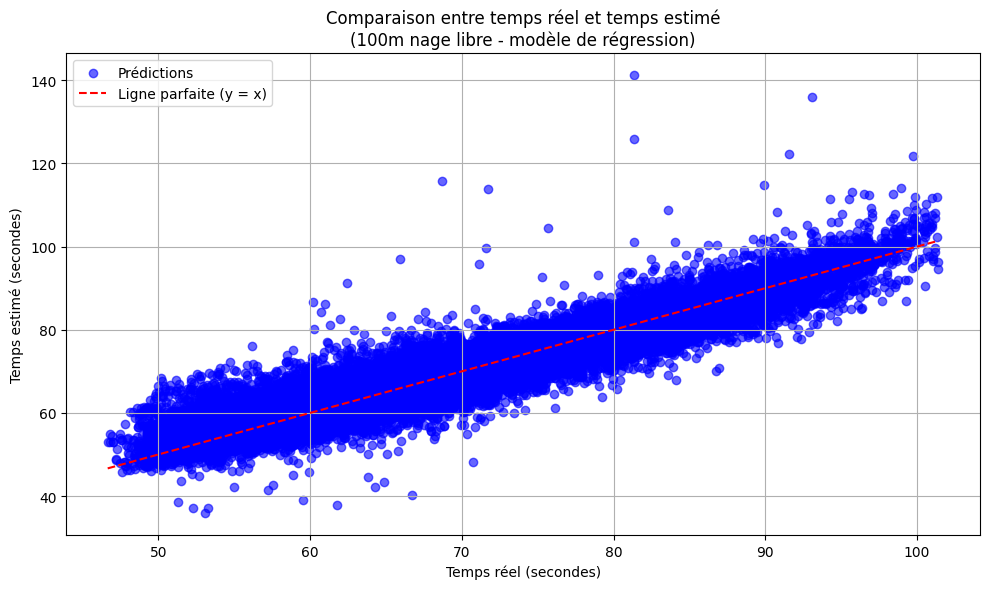

In [178]:
def predict(X, w, b):

    return np.dot(X, w) + b 


def rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

pr_y_pred = predict(x_test, w_final, b_final)
pr_y_test = y_test

pr_y_pred_original = scaler_y.inverse_transform(pr_y_pred.reshape(-1, 1))
pr_y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

pr_rmse_value_original = rmse(pr_y_test_original, pr_y_pred_original)

pr_rmse_percentage = (pr_rmse_value_original / np.mean(pr_y_test_original)) * 100

print(f"RMSE on the test set (original scale): {pr_rmse_value_original}")
print(f"RMSE en pourcentage sur l'ensemble de test: {pr_rmse_percentage:.2f}%")

pr_y_test_true = scaler_y.inverse_transform(pr_y_test)
pr_y_test_pred = scaler_y.inverse_transform(pr_y_pred.reshape(-1, 1))

# Création du graphique
plt.figure(figsize=(10, 6))
plt.scatter(pr_y_test_true, pr_y_test_pred, alpha=0.6, color='blue', label='Prédictions')
plt.plot([pr_y_test_true.min(), pr_y_test_true.max()],
         [pr_y_test_true.min(), pr_y_test_true.max()],
         'r--', label='Ligne parfaite (y = x)')
plt.xlabel("Temps réel (secondes)")
plt.ylabel("Temps estimé (secondes)")
plt.title("Comparaison entre temps réel et temps estimé\n(100m nage libre - modèle de régression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [179]:
# Select features and target
features = ['swimmer_num_id', 'age', 'sex_M', 'previous_time', 'pool_50m', 'days_since_last_race', 'trend_score', 'first_race_age']
target = 'time'

models = {}
scalers = {}

for (distance, stroke), df in event_dfs.items():

    X = df[features]
    y = df[target]

    # Split the df
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the df
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    scalers[f'{distance}_{stroke}'] = scaler

    def build_models():
        tf.random.set_seed(20)

        model_1 = Sequential([
            Dense(16, activation=ELU(alpha=1.0), input_shape=(x_train.shape[1],)),
            Dense(8, activation=ELU(alpha=1.0)),
            Dense(4, activation=ELU(alpha=1.0)),
            Dense(1, activation='linear')
        ], name='model_1')

        model_2 = Sequential([
            Dense(16, activation='relu', input_shape=(x_train.shape[1],)),
            Dense(8, activation='relu'),
            Dense(4, activation='relu'),
            Dense(1, activation='linear')
        ], name='model_2')

        model_3 = Sequential([
            Dense(4, activation='relu', input_shape=(x_train.shape[1],)),
            Dense(8, activation='relu'),
            Dense(4, activation='relu'),
            Dense(1, activation='linear')
        ], name='model_3')

        model_4 = Sequential([
            Dense(8, activation=ELU(alpha=1.0), input_shape=(x_train.shape[1],)),
            Dense(4, activation=ELU(alpha=1.0)),
            Dense(1, activation='linear')
        ], name='model_4')

        # model_list = [model_1, model_2, model_3, model_4]
        
        model_list = [model_1]

        return model_list

    nn_models = build_models()
    print(f"Training {distance} {stroke}...")

    for model in nn_models:
        start_time = time.time()
        model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
        )

        model._name = f"{distance}_{stroke}".replace(" ", "_")
        model.name = f"{distance}_{stroke}".replace(" ", "_")


        model.fit(
            x_train, y_train,
            epochs=500,
            batch_size=64,
            validation_split=0.1,
            verbose=0
        )


        yhat_train = model.predict(x_train)
        yhat_test = model.predict(x_test)

        # Check for NaNs in predictions
        if np.isnan(yhat_train).any() or np.isnan(yhat_test).any():
            print(f"Model {distance} {stroke} - Predictions contain NaNs")
            continue

        rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
        
        rmse_percentage = (rmse_test / np.mean(y_test)) * 100


        print(f"Model {model.name} - RMSE on Training Set: {rmse_train:.4f}")
        print(f"Model {model.name} - RMSE on Test Set: {rmse_test:.4f}\n")
        print(f"Model {model.name} - RMSE Percentage on Test Set: {rmse_percentage:.2f}%\n")

        print(f"Training time: {time.time() - start_time:.2f} seconds\n")
        
        # save the model
        models[f'{distance}_{stroke}'] = model

        # plt.figure(figsize=(10, 6))
        # plt.scatter(y_test, yhat_test, alpha=0.5, label="Predictions")
        # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect prediction")
        # plt.xlabel("True Times")
        # plt.ylabel("Predicted Times")
        # plt.title("Model Prediction vs. Actual Times")
        # plt.legend()
        # plt.grid(True)
        # plt.show()


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training 100 Backstroke...
3557/3557 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step
Model 100_Backstroke - RMSE on Training Set: 1.2437
Model 100_Backstroke - RMSE on Test Set: 1.2552

Model 100_Backstroke - RMSE Percentage on Test Set: 1.67%

Training time: 795.09 seconds

Training 100 Breaststroke...


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2906/2906 ━━━━━━━━━━━━━━━━━━━━ 2s 771us/step
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step
Model 100_Breaststroke - RMSE on Training Set: 1.4111
Model 100_Breaststroke - RMSE on Test Set: 1.4378

Model 100_Breaststroke - RMSE Percentage on Test Set: 1.69%

Training time: 684.21 seconds

Training 100 Butterfly...


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2522/2522 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
Model 100_Butterfly - RMSE on Training Set: 1.3058
Model 100_Butterfly - RMSE on Test Set: 1.3070

Model 100_Butterfly - RMSE Percentage on Test Set: 1.80%

Training time: 611.76 seconds

Training 100 Freestyle...


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6275/6275 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step
Model 100_Freestyle - RMSE on Training Set: 1.1486
Model 100_Freestyle - RMSE on Test Set: 1.1508

Model 100_Freestyle - RMSE Percentage on Test Set: 1.73%

Training time: 1378.48 seconds

Training 200 Freestyle...


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2912/2912 ━━━━━━━━━━━━━━━━━━━━ 2s 543us/step
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Model 200_Freestyle - RMSE on Training Set: 2.2909
Model 200_Freestyle - RMSE on Test Set: 2.3773

Model 200_Freestyle - RMSE Percentage on Test Set: 1.69%

Training time: 674.03 seconds

Training 200 Medley...


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
Model 200_Medley - RMSE on Training Set: 2.3870
Model 200_Medley - RMSE on Test Set: 2.3410

Model 200_Medley - RMSE Percentage on Test Set: 1.46%

Training time: 521.31 seconds

Training 400 Freestyle...


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2428/2428 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
Model 400_Freestyle - RMSE on Training Set: 5.6367
Model 400_Freestyle - RMSE on Test Set: 5.7079

Model 400_Freestyle - RMSE Percentage on Test Set: 1.91%

Training time: 522.57 seconds



Predictions

In [205]:
from datetime import datetime

# Inputs
new_results = {
    "swimmer": 'Gjon VATA',
    "race_date": '2025-05-27',
    "distance": 100,
    "stroke": 'Freestyle',
    "pool": '50m'
}

# --- Retrieve swimmer history for that event
event_key = (new_results['distance'], new_results['stroke'])
event_df = event_dfs.get(event_key)

if event_df is None:
    raise ValueError(f"No event data for {event_key}")

swimmer_history = event_df[event_df['swimmer_name'] == new_results['swimmer']].copy()
if swimmer_history.empty:
    raise ValueError(f"No history found for swimmer {new_results['swimmer']}")

swimmer_history = swimmer_history.sort_values(by='race_date', ascending=False)

# --- Fill in static features
new_results["swimmer_num_id"] = swimmer_history['swimmer_num_id'].iloc[0]
new_results["birth_year"] = pd.to_datetime(swimmer_history['birth_year'].iloc[0], errors='coerce').year
new_results["sex_M"] = swimmer_history['sex_M'].iloc[0]
new_results["first_race_age"] = swimmer_history['first_race_age'].iloc[0]

# --- Parse race date
new_results['race_date'] = pd.to_datetime(new_results['race_date'])

# --- Compute seasonal age
month = new_results['race_date'].month
year = new_results['race_date'].year
season_year = year - 1 if month <= 8 else year
new_results['age'] = season_year - new_results['birth_year']

# --- Get last race info (same swimmer, same distance, same stroke, before current race)
past_races = event_df[
    (event_df['swimmer_name'] == new_results['swimmer']) &
    (event_df['race_date'] < new_results['race_date'])
].sort_values(by='race_date', ascending=False)

if not past_races.empty:
    last_race = past_races.iloc[0]
    new_results["previous_time"] = last_race['time']
    new_results["days_since_last_race"] = (new_results['race_date'] - last_race['race_date']).days
    new_results["trend_score"] = last_race['trend_score']
else:
    new_results["previous_time"] = swimmer_history['time'].iloc[-1]
    new_results["days_since_last_race"] = 9999
    new_results["trend_score"] = 0

# --- Pool encoding
new_results["pool_50m"] = 1 if new_results["pool"] == "50m" else 0

# --- Prepare the input
features = ['swimmer_num_id', 'age', 'sex_M', 'previous_time', 'pool_50m',
            'days_since_last_race', 'trend_score', 'first_race_age']

input_df = pd.DataFrame([new_results])[features]

# --- Scaling
scaler_key = f"{new_results['distance']}_{new_results['stroke']}".replace(" ", "_")
scaler = scalers.get(scaler_key)
if scaler is None:
    raise ValueError(f"No scaler found for {scaler_key}")

input_scaled = scaler.transform(input_df)

# --- Prediction
model = models.get(scaler_key)
print(f"Using model for {scaler_key}: {model.name if model else 'None'}")
if model is None:
    raise ValueError(f"No model found for {scaler_key}")

prediction = model.predict(input_scaled)
predicted_time = prediction   
# --- Output
print(f"✅ Predicted time for {new_results['swimmer']} in {new_results['distance']}m {new_results['stroke']} on {new_results['race_date'].date()}: {predicted_time[0][0]:.2f} seconds")


Using model for 100_Freestyle: 100_Freestyle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ Predicted time for Gjon VATA in 100m Freestyle on 2025-05-27: 53.96 seconds
